### Basic Concepts: Nodes, Edges & State

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    string_val: str
    num_val: int

def modify_state(input: State):
    print(f'Current val: {input}')
    return input

graph = StateGraph(State)

graph.add_node('node_a', modify_state)
graph.add_node('node_b', modify_state)
graph.add_edge(START, 'node_a')
graph.add_edge('node_a', 'node_b')
graph.add_edge('node_b', END)

runnable = graph.compile()

In [1]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int


def modify_state(input: InputState):
    print(f"Current value: {input}")
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

### Visualize graph

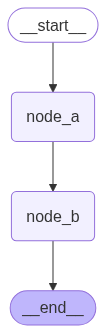

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [3]:
runnable.invoke({"string_value": "a"})

Current val: {}
Current val: {}


In [4]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

Current val: {}
Current val: {}


In [9]:
def modify_state(input: State):
    input['string_val'] += 'a'
    input['num_val'] += 1
    return input

graph = StateGraph(State)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)
runnable = graph.compile()

runnable.invoke({'string_val': '', 'num_val': 0})

{'string_val': 'aa', 'num_val': 2}

In [5]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)


graph.set_entry_point("branch_a")

runnable = graph.compile()

In [ ]:
try:
    runnable.invoke({"string_value": "a"})
except KeyError as e:
    print(e)

In [ ]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

### Why not use just LCEL?

In [8]:
from langchain_core.runnables import RunnableLambda

In [9]:
runnable = RunnableLambda(modify_state)

chain = runnable | runnable

In [ ]:
chain.invoke({"string_value": "a", "numeric_value": 1})

### Cycles and Conditional Edges

In [11]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


def router(input: InputState):
    if input["numeric_value"] < 5:
        return "branch_a"
    else:
        return "__end__"


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_conditional_edges(
    "branch_b", router, {"branch_a": "branch_a", "__end__": END}
)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [10]:
def router(input: State):
    if input['num_val'] < 5:
        return 'node_a'
    else:
        return '__end__'

graph = StateGraph(State)
graph.add_node('node_a', modify_state)
graph.add_node('node_b', modify_state)
graph.add_edge(START, 'node_a')
graph.add_edge('node_a', 'node_b')
graph.add_conditional_edges(
    'node_b',
    router,
    {'node_a': 'node_a', '__end__': END}
)

runnable = graph.compile()


In [11]:
runnable.invoke({'string_val': 'a', 'num_val': 1})

{'string_val': 'aaaaa', 'num_val': 5}

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

### Reducer functions

In [2]:
from typing import TypedDict, Annotated
from langgraph.graph import START, END, StateGraph
from operator import add

class State(TypedDict):
    constant: str
    str_val: Annotated[str, add]
    num_val: Annotated[int, add]
    ls: Annotated[list[str], add]

def modify_state(input: State):
    return input

graph = StateGraph(State)
graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)
runnable = graph.compile()

runnable.invoke({'constant': 'a', 'str_val': 'a', 'num_val': 1, 'ls': ['a']})

{'constant': 'a', 'str_val': 'aaaa', 'num_val': 4, 'ls': ['a', 'a', 'a', 'a']}

In [14]:
from typing import TypedDict, Annotated
from langgraph.graph import END, StateGraph
from operator import add


class InputState(TypedDict):
    no_change_value: str
    string_value: Annotated[str, add]
    numeric_value: Annotated[int, add]
    list_value: Annotated[list[str], add]


def modify_state(input: InputState):
    return input

In [15]:
graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [ ]:
runnable.invoke(
    {
        "no_change_value": "a",
        "string_value": "a",
        "numeric_value": 1,
        "list_value": ["a"],
    }
)

### Alternative State

In [7]:
from typing import TypedDict
from langgraph.graph import END, StateGraph

from pydantic import BaseModel

# class InputState(TypedDict):
#     string_value: str
#     numeric_value: int


class InputState(BaseModel):
      string_value: str
      numeric_value: int


def modify_state(input: InputState):
    # string_value = input["string_value"]
    string_value = input.string_value
    print(string_value)
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [10]:
try:
    runnable.invoke({"string_value": "a", "numeric_value": "a"})
except Exception as e:
    print(e)

1 validation error for InputState
numeric_value
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='a', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/int_parsing
